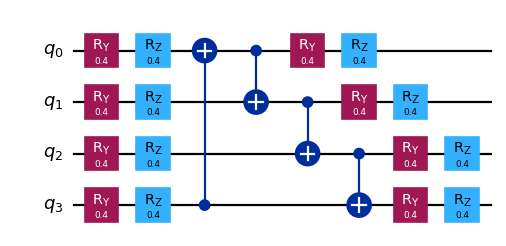

In [1]:
from qiskit.circuit.library import EfficientSU2

circuit = EfficientSU2(num_qubits=4, entanglement="circular", reps=1).decompose()
circuit.assign_parameters([0.4] * len(circuit.parameters), inplace=True)
circuit.draw("mpl", scale=0.8)

In [2]:
from qiskit.quantum_info import SparsePauliOp

observable = SparsePauliOp(["ZZZZ"])

In [3]:
from qiskit_ibm_runtime.fake_provider import FakeManilaV2

backend = FakeManilaV2()

In [4]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

pass_manager = generate_preset_pass_manager(
    optimization_level=1, backend=backend, initial_layout=[0, 1, 2, 3]
)

transpiled_qc = pass_manager.run(circuit)
print(f"Transpiled circuit depth: {transpiled_qc.depth(lambda x: len(x[1]) >= 2)}")

Transpiled circuit depth: 10


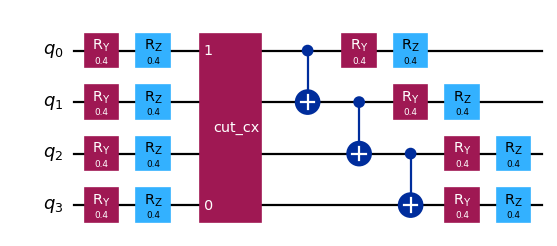

In [5]:
from circuit_knitting.cutting import cut_gates

# Find the indices of the distant gates
cut_indices = [
    i
    for i, instruction in enumerate(circuit.data)
    if {circuit.find_bit(q)[0] for q in instruction.qubits} == {0, 3}
]

# Decompose distant CNOTs into TwoQubitQPDGate instances
qpd_circuit, bases = cut_gates(circuit, cut_indices)

qpd_circuit.draw("mpl", scale=0.8)

In [6]:
import numpy as np
from circuit_knitting.cutting import generate_cutting_experiments

# Generate the subexperiments and sampling coefficients
subexperiments, coefficients = generate_cutting_experiments(
    circuits=qpd_circuit, observables=observable.paulis, num_samples=np.inf
)

In [7]:
print(f"Sampling overhead: {np.prod([basis.overhead for basis in bases])}")
print(f"Number of subexperiments: {len(subexperiments)}")
print(6 ** 3)

Sampling overhead: 9.0
Number of subexperiments: 6
216


In [8]:
# Transpile the decomposed circuit to the same layout
transpiled_qpd_circuit = pass_manager.run(subexperiments[100])

print(
    f"Original circuit depth after transpile: {transpiled_qc.depth(lambda x: len(x[1]) >= 2)}"
)
print(
    f"QPD subexperiment depth after transpile: {transpiled_qpd_circuit.depth(lambda x: len(x[1]) >= 2)}"
)
transpiled_qpd_circuit.draw("mpl", scale=0.8, idle_wires=False, fold=-1)

IndexError: list index out of range